<a href="https://colab.research.google.com/github/Wycology/dl_tea_mapping/blob/main/dl_tea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'><b> SATELLITE DATA FOR AGRICULTURAL ECONOMISTS</b></font>


<font color='blue'><b>THEORY AND PRACTICE</b></font>

**Mapping tea plantations in Central Kenya: _Deep Learning Approach_**


*David Wuepper, Lisa Biber-Freudenberger, Hadi, Wyclife Agumba Oluoch*

[Land Economics Group](https://www.ilr1.uni-bonn.de/en/research/research-groups/land-economics), University of Bonn, Bonn, Germany

---

# **Background**


---

In this tutorial, we introduce basics of using deep learning approach to segment tea fields with a practical example at the foot of Mount Kenya. We obtained high resolution Sentinel-2 satellite image from [Google Earth Engine](https://code.earthengine.google.com/60cf3e783458009bd8378eaded30f5c7). On the other hand, we obtained labels by manually digitizing tea plantations within QGIS using Google Satellite Hybrid basemap. The labels cover a small portion of the downloaded Satellite image so that we can train the model and use it to segment tea fields elsewhere.
We used torchgeo for this modeling task due to the following reasons:
1. It is simple to use, eliminating a lot of issues such as georeferencing, chipping, label creation.
2. It also maximally obtain training samples from the region of interest.

## Loading libraries
---
Since [torchgeo](https://torchgeo.readthedocs.io/en/latest/) is not natively installed in colab, we will have to install it. We will also install [torchseg](https://pypi.org/project/torchseg/0.0.1a1/) to help with the segmentation work. Other supporting libraries will just be imported as they are already pre-installed in colab.

In [ ]:
# Install libraries not already available in colab
!pip install torchgeo
!pip install torchseg

In [6]:
# Import the necessary libraries

import json
import torch
import rasterio
import torchseg
import torchgeo
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import rasterio.sample
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchgeo.transforms import AppendNDVI
from rasterio.transform import from_bounds
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.datasets import VectorDataset, RasterDataset, stack_samples
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

After installing the libraries, we make an important step of confirming the working directory. This is important since both our image and gpkg will be read from this location so we need to be sure of the path. We can use `pwd` function to print it.

In [ ]:
pwd # Confirm the working directory

'/content'

## **Visualize the data**

Let us confirm that our data is as expected. That is, we have raster and label data overlaying. We simply define a function which achieves the plotting. In the function:
* `raster_path`: Path to the raster file.
* `vector_path`: Path to the vector file.
* `rgb_bands`: A tuple specifying the band order for RGB.
* `stretch=True`: A boolean, whether to apply contrast stretching to enhance colors.

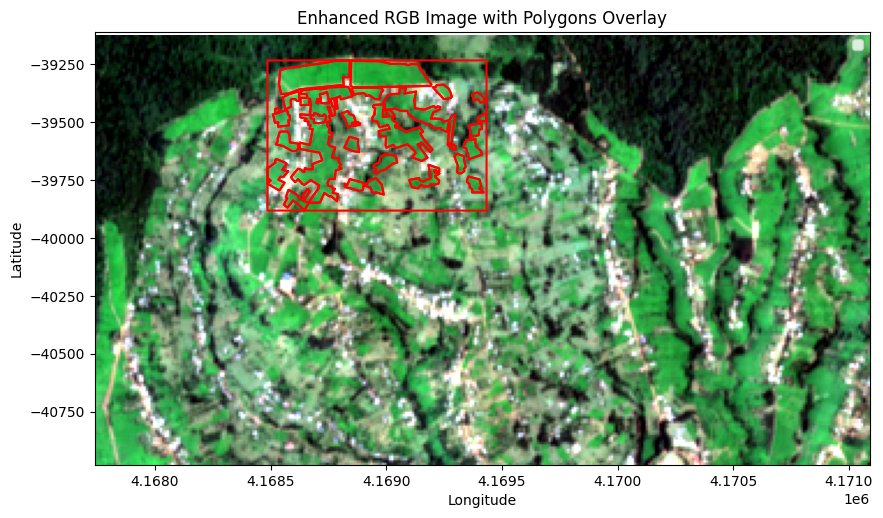

In [19]:
def plot_rgb_with_geopandas(raster_path, vector_path, rgb_bands=(3, 2, 1), stretch=True):

    with rasterio.open(raster_path) as src:
        img = src.read(rgb_bands)

        # Handle NaNs (nodata)
        mask = src.dataset_mask()

        if stretch:
            # Stretch the RGB bands individually
            img_stretched = np.zeros_like(img, dtype=np.float32)
            for i in range(img.shape[0]):
                band = img[i]
                p2, p98 = np.percentile(band[band > 0], (2, 98))  # Ignore zeros/NaNs
                band = np.clip((band - p2) / (p98 - p2), 0, 1)
                img_stretched[i] = band
            img = img_stretched

        fig, ax = plt.subplots(figsize=(10, 10))

        rasterio.plot.show(
            img,
            ax=ax,
            transform=src.transform,
            cmap=None,
            adjust=None
        )

        # Read and plot the vector
        gdf = gpd.read_file(vector_path)
        gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.5)

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend(["Polygons"], loc="upper right")
        plt.title("Enhanced RGB Image with Polygons Overlay")
        plt.show()

if __name__ == "__main__":
    raster_file = "/content/s2_large.tif"
    polygons = "/content/vect.gpkg"
    plot_rgb_with_geopandas(raster_path=raster_file, vector_path=polygons)

# Defining the Dataset
---
With `torchgeo`, we do not have to pre-chip the satellite image into small chips of say 256 by 256 pixels. This it achieves on the fly. However, we need to tell it the path to where our satellite image is. In fact, we can have several large images here. For now, it is the only _.tif_ image our working directory, wo we define the class as follows:

In [ ]:
# Define the GeoTiff dataset class

class GeoTiffDataset(RasterDataset):
  filename_glob = "*.tif"
raster_data = GeoTiffDataset(paths = "/content")

In that case, raster_data is a blueprint of the satellite image we have in the directory. Next, we do the same for the label data. This label data is a _.gpkg_ file which has a column stating the identity of the each polygon as either tea or not tea. In other words, the class column. Here, we call the class column as `tea_no_tea`. This is very important as it is what the library uses to create a label binary layer under the hood to intersect with the satellite image. We achieve this as follows:

In [ ]:
# Define the label (here vector but can also be mask raster) dataset class.
# Remember to include label name. Never forget this!

class LabelDataset(VectorDataset):
  filename_glob = "*.gpkg"
label_data = LabelDataset(paths = "/content", label_name = "tea_no_tea")

## Combining `raster_data` and `label_data`
___
Now that we have blueprints of both raster_data and label_data, the next step is to intersect the two. This will behave like _cropping_ or _clipping_ the raster to the extent of the label_data. This is the reason why we are not worried that the raster extent is bigger than the label extent. Chips for training the model will only be ontained from where the two datasets intersect/overlap. Regions outside the label_data will not be sampled. As simple as it can get, we achieve this intersection using an _&_ operator.

In [ ]:
# Create the intersection of the raster and vector/label datasets

training_data = raster_data & label_data

Converting LabelDataset res from (0.0001, 0.0001) to (10.0, 10.0)


You notice the printout that **Converting LabelDataset res from (0.0001, 0.0001) to (10.0, 10.0)**. This tells us that our vector label data with polygons has now been converted to a binary raster under the hood with a pixel size similar to that of the satellite image we have - Sentinel-2. Something imortant to note also is that the pixels in both layers has been **aligned**.

# Create sampler
---
Since we did not pre-chip the satellite image, we need to provide a sampler which will do the task of obtaining small chips from the original image and pushing them to the model for training at a time. This is important since we cannot push the whole image to the model at once. In this case, we use [RandomGeoSampler](https://torchgeo.readthedocs.io/en/latest/api/samplers.html) which randomly picks unique but overlaping patches from the region of interest. This allows us to pick more patches from the study area than if we pre-chipped it. We achieve this as follows:

In [ ]:
# Define the sampler that will execute the task of extracting samples

sampler = RandomGeoSampler(dataset = training_data, size = 32, length = 1000)

# **Create data loader**
---
Once we have created a sampler that splits the big image to small patches within the region of interest, we do the next task of creating a data loader. This is what collected the slices or patches from the sampler in groups and pushes them to the model for training, validation, and testing as well as prediction tasks. This is attained as follows:

In [ ]:
# Initialize the dataloader. This is the function that will be serving the role of availing batches of extracted samples for model training
dataloader = DataLoader(
    dataset = training_data,
    batch_size = 50,
    sampler = sampler,
    collate_fn = stack_samples
)

## Check the loader

Here we then check whether the dataloader is working as expected. That is, whether it is getting 50 small images and 50 labels from the sampler to take to the model.

In [ ]:
# Iterate through the dataloader to confirm that it is able to load the data

for batch in dataloader:
  image = batch["image"][:, :11, :, :]
  mask = image[:, -1, :, :]

  print(f"Image batch length: {len(image)}")
  print(f"Mask batch length: {len(mask)}")
  break

Image batch length: 50
Mask batch length: 50


# **Define the model**
---

Here we then remember our torchseg to give us a model/method to train our data which the sampler has sliced and the loader has gathered. torchseg has several models but we will use Unet which is a very common deep learning model, especially for segmentation tasks. In this setup, `encoder_name="resnet18"` specifies the encoder, which is the feature extractor part. `encoder_weights=False` means we are not using pre-trained weights from imagenet, we will train it from scratch from our data. `in_channels=10` indicates that our Sentinel-2 image has 10 channels/bands. This is different from 3 channels of RGB. Lastly `classes=2` sets the number of output classes, which in our case is 2, tea and non-tea.


In [ ]:
# We will use Unet model from torchseg.
# Which is pretrained so we do not need to build it from scratch

model = torchseg.Unet(
    encoder_name = "resnet18",
    encoder_weights = False,
    in_channels = 10,
    classes = 2
)

## Move the model to the device

After defining the model. We need to move it to the right device. If a GPU is available, we should use it to speed up the model training. Something we could not do with classical machine learning. However, if we do not have GPU in our machine, we fall back to CPU. As you can imagine, there is a lot of data going to the model at a time and GPU excels in such kinds of analyses.

In [ ]:
# Use cuda if available, otherwise cpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Defining the loss function and optimizer

We then set up the loss function and optimizer, which tell the model how wrong it is at each epoch and how to improve weights in the next training episode/epoch. `crossEntropyLoss` is useful for multiclass/binary classification. We go ahead and tell it to ignore pixels labelled -1. Remember in our label we only had 0 (no tea) and 1 (tea). However, sometimes we may have unknowns and label them as -1 or any other number. Such unknowns should be ignored in loss calculation.`Adam` (Adaptive Moment Estimation) is an optimizer that automatically adjusts the learning rate during training. It helps to attain faster and more stable convergence than older methods like SGD. `lr=0.001` marks the initial learning rate. It is a smaller number that controls how big the model's updates are. 0.001 is a common default that works well. If too low, the model can be very slow.

In [ ]:
# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss(ignore_index = -1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Evaluation metrics

When training our model, we need to know whether the model is learning from the samples it is exposed to during each epoch. Therefore, we need to capture some evaluation metrics. There are so many evaluation metrics such as loss, accuracy, intersection over union, F1, recall etc. Here, we will only look at two for now; loss and accuracy.

In [ ]:
# Evaluation metrics

metrics = {"loss": [], "accuracy": []}

# **Training loop**
---

Most of the things going into the training loop we have already defined. Note that `num_epochs` is the number of times we want the model to go through all samples. We can set it to larger number if we see that the model is still learning. However, making it too big can delay the whole process and maybe waste precious energy/electricity. Set it modestly. Also note that we are capturing the evaluation metrics in a json file so that we can load them later to visualize.

In [ ]:
# Training loop

num_epochs = 10
best_accuracy = 0.0 # Track the best accuracy, normally best IoU.

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  total_correct = 0
  total_pixels = 0

  with tqdm(dataloader, desc = f"Epoch {epoch + 1} / {num_epochs}") as pbar:
    for batch in pbar:
      images = batch["image"][:, :11, :, :].to(device)
      masks = batch["mask"].to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, masks.long())
      epoch_loss += loss.item()

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate accuracy
      preds = torch.argmax(outputs, dim = 1)
      total_correct += (preds == masks).sum().item()
      total_pixels += masks.numel()

      pbar.set_postfix(loss = loss.item())

  epoch_accuracy = total_correct / total_pixels * 100
  metrics["loss"].append(epoch_loss)
  metrics["accuracy"].append(epoch_accuracy)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

  # Save training metrics
  with open("/content/training_metrics.json", "w") as f:
    json.dump(metrics, f)

  print("Training metrics saved to '/content/training_metrics.json")

  # Save best model based on accuracy
  if epoch_accuracy > best_accuracy:
    best_accuracy = epoch_accuracy
    torch.save(model.state_dict(), "/content/best_tea_model.pth")
    print(f"Best model saved with accuracy: {best_accuracy: .2f}%")


Epoch 1 / 10: 100%|██████████| 20/20 [01:56<00:00,  5.82s/it, loss=0.238]


Epoch [1/10], Loss: 7.1037, Accuracy: 83.86%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  83.86%


Epoch 2 / 10: 100%|██████████| 20/20 [01:53<00:00,  5.68s/it, loss=0.169]


Epoch [2/10], Loss: 3.9426, Accuracy: 91.66%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  91.66%


Epoch 3 / 10: 100%|██████████| 20/20 [01:53<00:00,  5.68s/it, loss=0.136]


Epoch [3/10], Loss: 3.0447, Accuracy: 93.57%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  93.57%


Epoch 4 / 10: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it, loss=0.12]


Epoch [4/10], Loss: 2.4743, Accuracy: 94.80%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  94.80%


Epoch 5 / 10: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it, loss=0.0947]


Epoch [5/10], Loss: 2.0758, Accuracy: 95.68%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  95.68%


Epoch 6 / 10: 100%|██████████| 20/20 [01:53<00:00,  5.69s/it, loss=0.0944]


Epoch [6/10], Loss: 1.7776, Accuracy: 96.38%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  96.38%


Epoch 7 / 10: 100%|██████████| 20/20 [01:52<00:00,  5.63s/it, loss=0.0674]


Epoch [7/10], Loss: 1.5361, Accuracy: 96.99%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  96.99%


Epoch 8 / 10: 100%|██████████| 20/20 [01:53<00:00,  5.69s/it, loss=0.0625]


Epoch [8/10], Loss: 1.3699, Accuracy: 97.33%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  97.33%


Epoch 9 / 10: 100%|██████████| 20/20 [01:52<00:00,  5.63s/it, loss=0.065]


Epoch [9/10], Loss: 1.2245, Accuracy: 97.68%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  97.68%


Epoch 10 / 10: 100%|██████████| 20/20 [01:52<00:00,  5.61s/it, loss=0.0493]

Epoch [10/10], Loss: 1.0771, Accuracy: 98.02%
Training metrics saved to '/content/training_metrics.json
Best model saved with accuracy:  98.02%


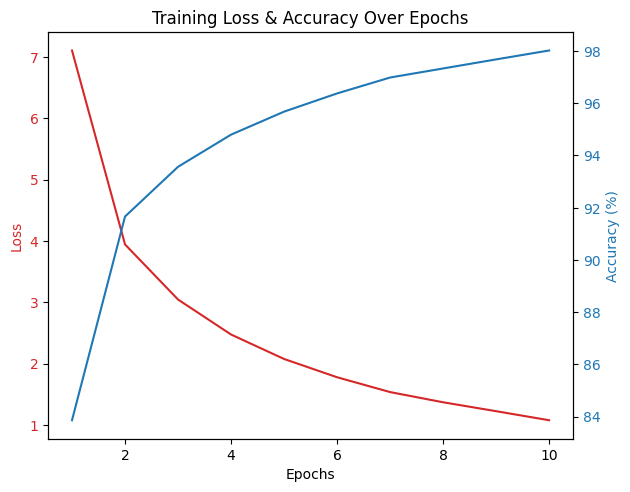

In [ ]:
# Load training metrics from JSON file
with open("/content/training_metrics.json", "r") as f:
    metrics = json.load(f)

# Extract loss and accuracy values
loss_values = metrics["loss"]
accuracy_values = metrics["accuracy"]
epochs = range(1, len(loss_values) + 1)

# Create the plots
fig, ax1 = plt.subplots()

# Plot loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(epochs, loss_values, label="Loss", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy (%)", color="tab:blue")
ax2.plot(epochs, accuracy_values, label="Accuracy", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

fig.tight_layout()
plt.title("Training Loss & Accuracy Over Epochs")
plt.show()

# Prediction over the whole study area

In [ ]:
# Set model to evaluation mode

model.eval()

# Create a GridGeoSampler for full coverage prediction

grid_sampler = GridGeoSampler(
    dataset=raster_data,
    size=32,  # Same as training
    stride=16  # Overlapping to avoid edge artifacts
)


In [ ]:
# Iterate through the dataloader to confirm that it is able to load the data
class GeoTiffDataset(RasterDataset):
  filename_glob = "*s2_large.tif"
raster_data = GeoTiffDataset(paths = "/content")
# Create prediction dataloader
pred_dataloader = DataLoader(
    dataset=raster_data,
    batch_size=50,
    sampler=grid_sampler,
    collate_fn=stack_samples
)
for batch in pred_dataloader:
  image = batch["image"][:, :11, :, :]

  print(f"Image batch length: {len(image)}")
  print(batch.keys())
  break

Image batch length: 50
dict_keys(['crs', 'bounds', 'image'])


In [ ]:
# Get raster metadata from the first file for output

with rasterio.open(raster_data.files[0]) as src:
    profile = src.profile
    transform = src.transform
    crs = src.crs
    height = src.height
    width = src.width

# Initialize empty arrays
full_pred = np.zeros((height, width), dtype=np.float32)
count = np.zeros((height, width), dtype=np.uint8)

# Make predictions
with torch.no_grad():
    for batch in tqdm(pred_dataloader, desc="Making predictions"):
        # Handle image bands
        images = batch["image"]
        if images.shape[1] > 10:
            images = images[:, :10, :, :]
        images = images.to(device)

        # Get predictions
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Process each prediction
        for i in range(len(preds)):
            bbox = batch["bounds"][i]
            minx, maxx = bbox.minx, bbox.maxx
            miny, maxy = bbox.miny, bbox.maxy

            # Convert to pixel coordinates
            col_off, row_off = ~transform * (minx, maxy)
            col_off, row_off = int(col_off), int(row_off)

            # Get predicted patch dimensions
            pred_height, pred_width = preds[i].shape[-2], preds[i].shape[-1]

            # Calculate valid window in output array
            row_start = max(row_off, 0)
            col_start = max(col_off, 0)
            row_end = min(row_off + pred_height, height)
            col_end = min(col_off + pred_width, width)

            # Calculate corresponding window in prediction
            pred_row_start = max(0, -row_off)
            pred_col_start = max(0, -col_off)
            pred_row_end = pred_row_start + (row_end - row_start)
            pred_col_end = pred_col_start + (col_end - col_start)

            # Only proceed if we have valid dimensions
            if (row_end > row_start) and (col_end > col_start):
                full_pred[row_start:row_end, col_start:col_end] += preds[i, pred_row_start:pred_row_end, pred_col_start:pred_col_end]
                count[row_start:row_end, col_start:col_end] += 1

# Average predictions
valid_mask = count > 0
full_pred[valid_mask] = full_pred[valid_mask] / count[valid_mask]
full_pred = np.round(full_pred).astype(np.uint8)
full_pred[~valid_mask] = 255  # nodata

# Update and save output
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw',
    nodata=255
)

with rasterio.open('/content/full_prediction.tif', 'w', **profile) as dst:
    dst.write(full_pred, 1)
    dst.write_colormap(1, {
        0: (0, 100, 0, 255),    # Green for class 0
        1: (255, 215, 0, 255),   # Gold for class 1
        255: (0, 0, 0, 0)        # Transparent for nodata
    })

print("Prediction saved as '/content/full_prediction.tif'")


Making predictions: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]

Prediction saved as '/content/full_prediction.tif'


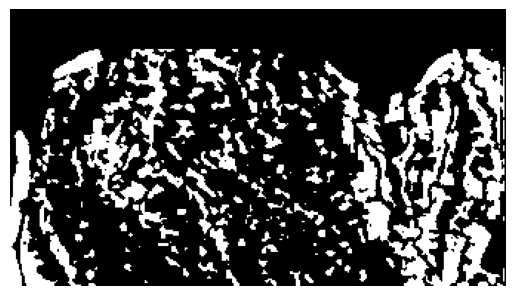

In [ ]:
with rasterio.open('/content/full_prediction.tif') as src:
    pred = src.read(1)

# Plot
plt.imshow(pred, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# 1. Load prediction raster
with rasterio.open('/content/full_prediction.tif') as src:
    pred_raster = src.read(1)
    transform = src.transform

# 2. Load evaluation points
gdf = gpd.read_file('/content/eval.gpkg')

# 3. Extract predicted values at point locations
coords = [(x,y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]

with rasterio.open('/content/full_prediction.tif') as src:
    sampled_pred = list(src.sample(coords))
    sampled_pred = np.array([val[0] for val in sampled_pred])

# 4. Remove nodata points (255)
valid_idx = sampled_pred != 255
sampled_pred = sampled_pred[valid_idx]
true_labels = gdf.loc[valid_idx, 'tea_no_tea'].values

# 5. Run evaluation
print("Accuracy:", accuracy_score(true_labels, sampled_pred))
print("Confusion Matrix:\n", confusion_matrix(true_labels, sampled_pred))
print("Classification Report:\n", classification_report(true_labels, sampled_pred))


Accuracy: 0.975
Confusion Matrix:
 [[99  1]
 [ 4 96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.99      0.96      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

